# German Credit Dataset

En este Notebook vamos a estudiar el efecto del fairness haciendo uso de la edad o el sexo como atributos sensibles. Para ello utilizaremos el operador lógico OR.

In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install tensorflow
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given

from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

c:\Users\sbenitez\AppData\Local\Programs\Python\Python312\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\sbenitez\AppData\Local\Programs\Python\Python312\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.

Cargamos los datos y codificamos nuestra variable

In [4]:
# Preprocesamiento personalizado
def custom_preprocessing(df):
    # Mapeo del sexo
    mapping = {
        'A91': 1,  # male: divorced/separated
        'A93': 1,  # male: single
        'A94': 1,  # male: married/widowed
        'A92': 0,  # female: divorced/separated/married
        'A95': 0   # female: single
    }
    df['sex'] = df['personal_status'].str.upper().map(mapping)
    
    # Creamos la nueva variable combinada (1 si es mujer O menor de 25 años)
    df['woman_or_young'] = ((df['sex'] == 0) | (df['age'] < 25)).astype(int)
    
    return df

# Cargamos el dataset con la nueva variable sensible
dataset_german = GermanDataset(
    protected_attribute_names=['woman_or_young'],  # Nueva variable como atributo sensible
    privileged_classes=[lambda x: x == 0],        # Privilegiados son los que NO son (mujer o joven)
    features_to_drop=['personal_status', 'foreign_worker', 'sex', 'age'],  # Eliminamos las originales
    custom_preprocessing=custom_preprocessing
)

# Ajustamos labels para xgboost (deben empezar en 0)
dataset_german.labels[dataset_german.labels.ravel() == 2] = dataset_german.labels[dataset_german.labels.ravel() == 2] - 2
dataset_german.unfavorable_label = dataset_german.unfavorable_label - 2

# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset_german.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset_german.protected_attribute_names[0]  # woman_or_young
privileged_groups = [{'woman_or_young': 0}]  # Hombres >=25 años
unprivileged_groups = [{'woman_or_young': 1}]  # Mujeres O <25 años

print(f'Dimensiones del conjunto de datos: {dataset_german.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset_german.favorable_label)
print("Label del grupo desfavorable:", dataset_german.unfavorable_label)

Dimensiones del conjunto de datos: (1000, 55)
Grupos privilegiados: [{'woman_or_young': 0}]
Grupos no privilegiados: [{'woman_or_young': 1}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


In [5]:
# Vamos a ver los nombres de las columnas que tiene el dataset resultante
print(dataset_german.feature_names)

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'number_of_credits', 'people_liable_for', 'woman_or_young', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192']


In [6]:
# Para comprobar que hemos añadido la variable sex correctamente vamos a ver cuantos hombres y mujeres hay:
df_prueba = dataset_german.convert_to_dataframe()[0]
print(df_prueba['woman_or_young'].unique())       
print(df_prueba['woman_or_young'].value_counts())

[1. 0.]
woman_or_young
1.0    625
0.0    375
Name: count, dtype: int64


## Aplicación algorítmica

In [7]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

In [8]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: total: 0 ns
Wall time: 12.7 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7373
AUC: 0.7396
Balanced accuracy: 0.6907
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.2230
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0961
Sufficiency ( |ΔPPV| ) : 0.0268
CPU times: total: 156 ms
Wall time: 162 ms


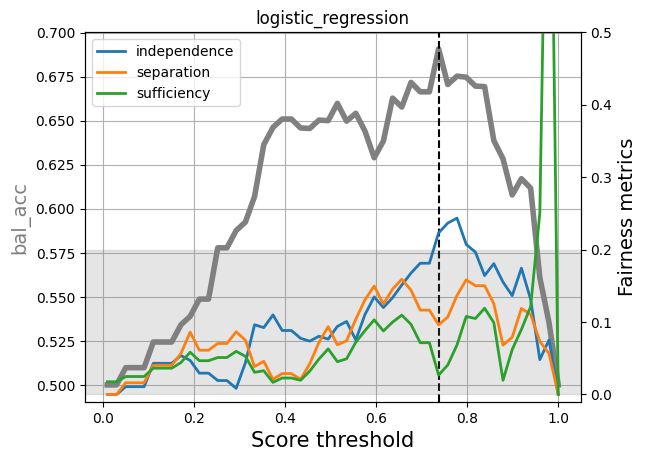

In [9]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [10]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.7373
AUC: 0.7509
Balanced accuracy: 0.7408
Accuracy: 0.6933
Independence ( |ΔP(Y_pred = 1)| ): 0.1840
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0107
Sufficiency ( |ΔPPV| ) : 0.0083


In [11]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: total: 500 ms
Wall time: 262 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7308
Balanced accuracy: 0.7213
Accuracy: 0.7200
Independence ( |ΔP(Y_pred = 1)| ): 0.0651
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1384
Sufficiency ( |ΔPPV| ) : 0.1061
CPU times: total: 547 ms
Wall time: 103 ms


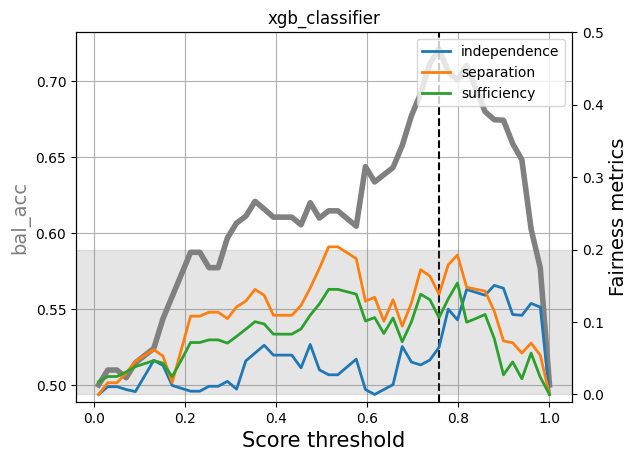

In [12]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [13]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7694
Balanced accuracy: 0.7197
Accuracy: 0.6933
Independence ( |ΔP(Y_pred = 1)| ): 0.1650
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0558
Sufficiency ( |ΔPPV| ) : 0.1000


## Técnicas de Preprocesamiento

### Reweighting

In [14]:
%%time 
# Nombramos al modelo
fairness_method = '_reweighting'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_copy = PreProcessor.transform(data_train_copy)
data_val_copy = PreProcessor.transform(data_val_copy)
data_test_copy = PreProcessor.transform(data_test_copy)

CPU times: total: 0 ns
Wall time: 5.51 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7382
Balanced accuracy: 0.6848
Accuracy: 0.6642
Independence ( |ΔP(Y_pred = 1)| ): 0.0976
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1487
Sufficiency ( |ΔPPV| ) : 0.0442
CPU times: total: 156 ms
Wall time: 157 ms


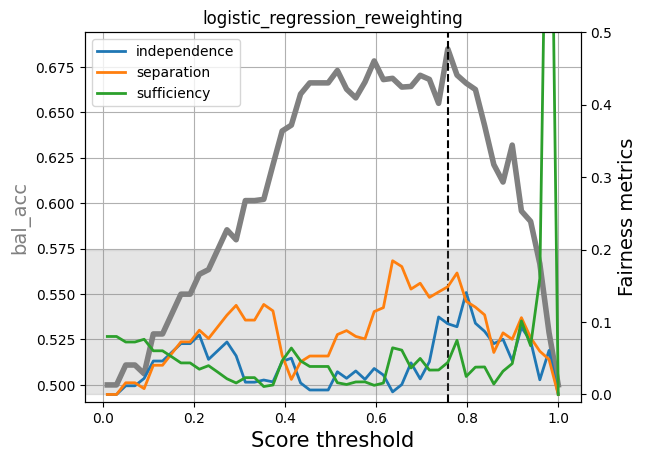

In [15]:
%%time 

# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7308
Balanced accuracy: 0.7234
Accuracy: 0.7199
Independence ( |ΔP(Y_pred = 1)| ): 0.0278
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1384
Sufficiency ( |ΔPPV| ) : 0.0412
CPU times: total: 1.34 s
Wall time: 281 ms


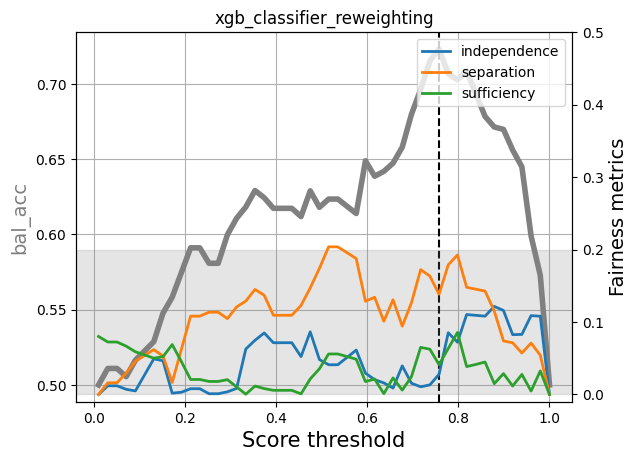

In [16]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

### Disparate Impact Remover

In [17]:
%%time 
# Nombramos al modelo
fairness_method = '_di_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_copy = PreProcessor.fit_transform(data_train_copy)
data_val_copy = PreProcessor.fit_transform(data_val_copy)
data_test_copy = PreProcessor.fit_transform(data_test_copy)

CPU times: total: 156 ms
Wall time: 165 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7171
AUC: 0.7316
Balanced accuracy: 0.6961
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.2094
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1237
Sufficiency ( |ΔPPV| ) : 0.0595
CPU times: total: 453 ms
Wall time: 478 ms


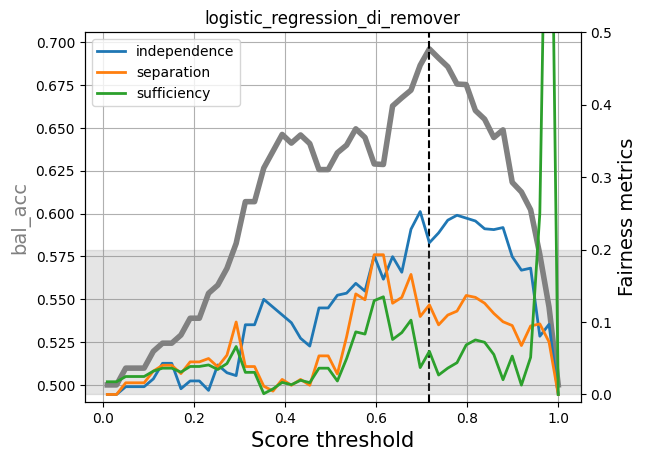

In [18]:
%%time 
# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.8788
AUC: 0.7320
Balanced accuracy: 0.6898
Accuracy: 0.6533
Independence ( |ΔP(Y_pred = 1)| ): 0.2111
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0981
Sufficiency ( |ΔPPV| ) : 0.0238
CPU times: total: 1.22 s
Wall time: 264 ms


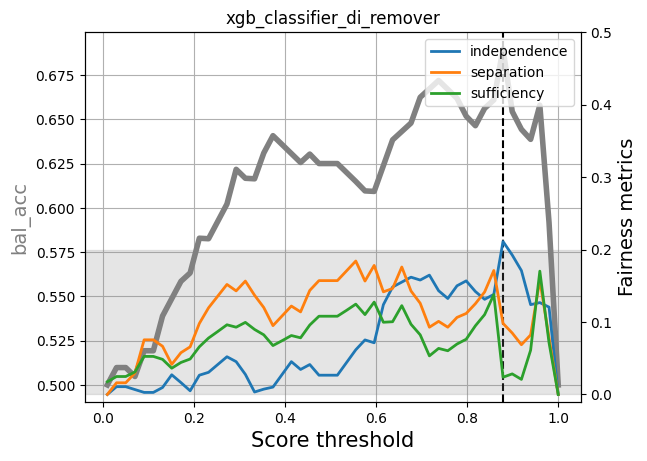

In [19]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])


# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

## Técnicas de Procesamiento Interno

### Adversarial Debiasing

In [20]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=125)

models[model_name].fit(data_train_copy)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

epoch 0; iter: 0; batch classifier loss: 78.621681; batch adversarial loss: 0.709529
epoch 1; iter: 0; batch classifier loss: 66.279922; batch adversarial loss: 0.713049
epoch 2; iter: 0; batch classifier loss: 33.323647; batch adversarial loss: 0.648044
epoch 3; iter: 0; batch classifier loss: 41.418068; batch adversarial loss: 0.660711
epoch 4; iter: 0; batch classifier loss: 35.088539; batch adversarial loss: 0.703762
epoch 5; iter: 0; batch classifier loss: 53.583359; batch adversarial loss: 0.732290
epoch 6; iter: 0; batch classifier loss: 52.067230; batch adversarial loss: 0.673974
epoch 7; iter: 0; batch classifier loss: 39.922180; batch adversarial loss: 0.676108
epoch 8; iter: 0; batch classifier loss: 43.895981; batch adversarial loss: 0.690053
epoch 9; iter: 0; batch classifier loss: 44.236500; batch adversarial loss: 0.698933
epoch 10; iter: 0; batch classifie

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7171
AUC: 0.4963
Balanced accuracy: 0.5915
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.0317
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1111
Sufficiency ( |ΔPPV| ) : 0.0468
CPU times: total: 234 ms
Wall time: 232 ms


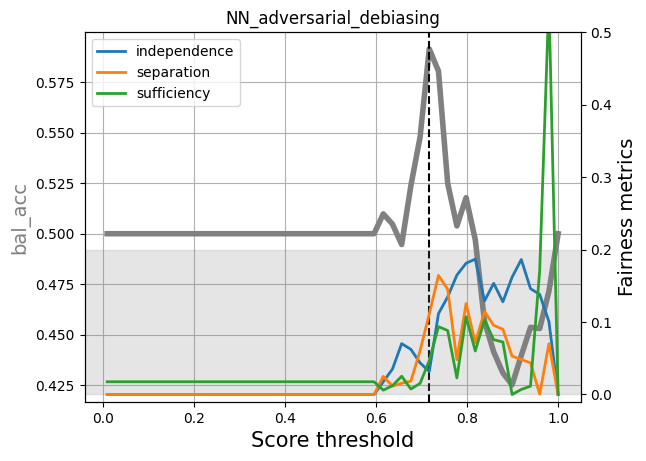

In [21]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios

In [22]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 97.776794
epoch 1; iter: 0; batch classifier loss: 70.418625
epoch 2; iter: 0; batch classifier loss: 83.197479
epoch 3; iter: 0; batch classifier loss: 27.762320
epoch 4; iter: 0; batch classifier loss: 55.345074
epoch 5; iter: 0; batch classifier loss: 65.497093
epoch 6; iter: 0; batch classifier loss: 33.464401
epoch 7; iter: 0; batch classifier loss: 58.547024
epoch 8; iter: 0; batch classifier loss: 52.990086
epoch 9; iter: 0; batch classifier loss: 42.530312
epoch 10; iter: 0; batch classifier loss: 44.348518
epoch 11; iter: 0; batch classifier loss: 55.894272
epoch 12; iter: 0; batch classifier loss: 54.346046
epoch 13; iter: 0; batch classifier loss: 48.881687
epoch 14; iter: 0; batch classifier loss: 58.125923
epoch 15; iter: 0; batch classifier loss: 28.092894
epoch 16; iter: 0; batch classifier loss: 35.921562
epoch 17; iter: 0; batch classifier loss: 33.838936
epoch 18; iter: 0; batch classifier loss: 45.011959
epoch 19; iter: 0; bat

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.7174
Balanced accuracy: 0.6812
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.1245
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0975
Sufficiency ( |ΔPPV| ) : 0.0641
CPU times: total: 172 ms
Wall time: 162 ms


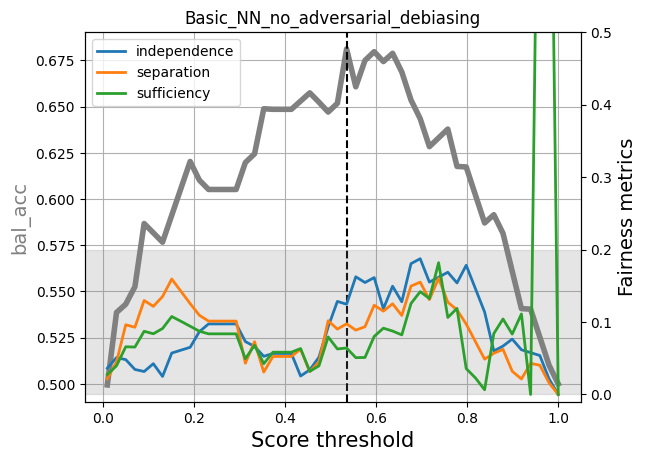

In [23]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Prejudice Remover

In [24]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

CPU times: total: 31.2 ms
Wall time: 3.06 s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.6565
AUC: 0.7386
Balanced accuracy: 0.6973
Accuracy: 0.7133
Independence ( |ΔP(Y_pred = 1)| ): 0.1121
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0765
Sufficiency ( |ΔPPV| ) : 0.0455
CPU times: total: 141 ms
Wall time: 4.07 s


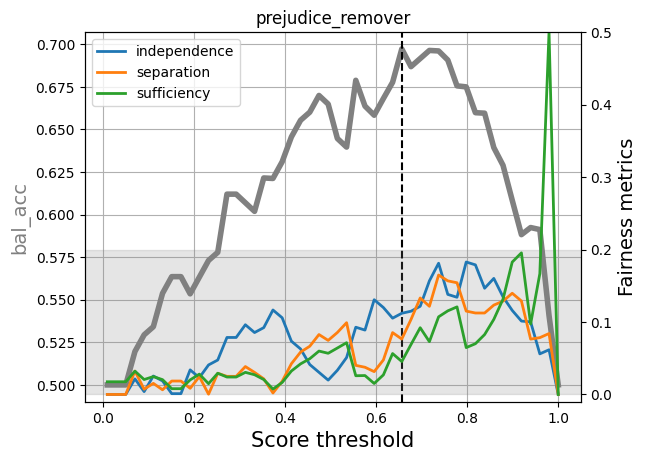

In [25]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Técnicas de Postprocesamiento

### Equalized Odds

#### Usando Labels

In [26]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

CPU times: total: 15.6 ms
Wall time: 15.3 ms


Threshold corresponding to *best balanced accuracy*: 0.7778
AUC: 0.7396
Balanced accuracy: 0.6955
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.1166
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0394
Sufficiency ( |ΔPPV| ) : 0.0067


CPU times: total: 234 ms
Wall time: 254 ms


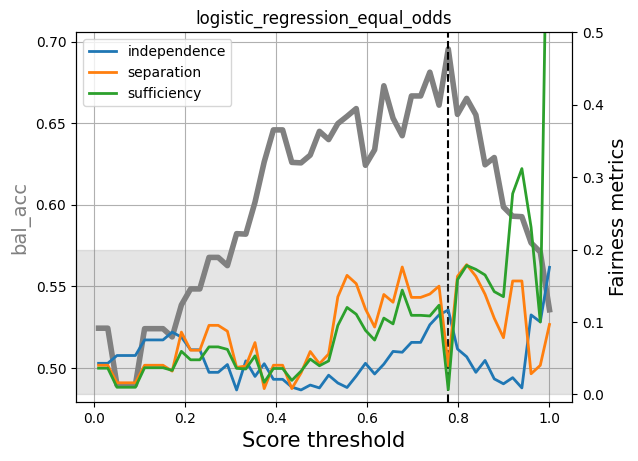

In [27]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [28]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

CPU times: total: 578 ms
Wall time: 137 ms


Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7308
Balanced accuracy: 0.7213
Accuracy: 0.7200
Independence ( |ΔP(Y_pred = 1)| ): 0.0651
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1384
Sufficiency ( |ΔPPV| ) : 0.1061


CPU times: total: 375 ms
Wall time: 304 ms


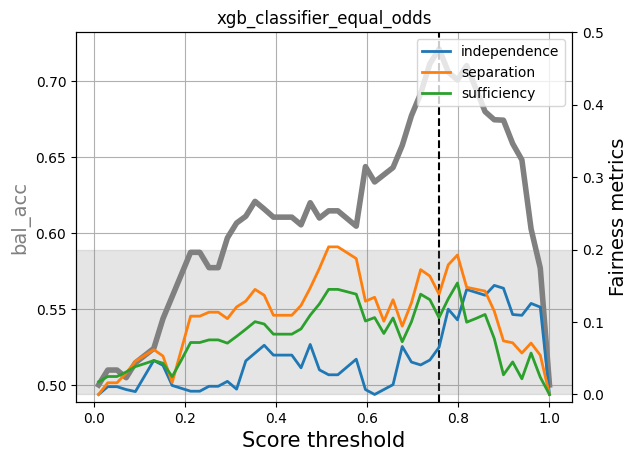

In [29]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Usando Scores

In [30]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 31.2 ms
Wall time: 27.2 ms


In [31]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.7373
AUC: 0.7396
Balanced accuracy: 0.6967
Accuracy: 0.7000
Independence ( |ΔP(Y_pred = 1)| ): 0.3305
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1041
Sufficiency ( |ΔPPV| ) : 0.0059


Results for logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7396
Balanced accuracy: 0.6277
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1075
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0425
Sufficiency ( |ΔPPV| ) : 0.1629


Results for logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.6363
AUC: 0.7396
Balanced accuracy: 0.6788
Accuracy: 0.7267
Independence ( |ΔP(Y_pred = 1)| ): 0.0770
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0988
Sufficiency ( |ΔPPV| ) : 0.0886




In [32]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 344 ms
Wall time: 111 ms


In [33]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7308
Balanced accuracy: 0.7163
Accuracy: 0.7133
Independence ( |ΔP(Y_pred = 1)| ): 0.0543
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1303
Sufficiency ( |ΔPPV| ) : 0.1037


Results for xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7308
Balanced accuracy: 0.7112
Accuracy: 0.7067
Independence ( |ΔP(Y_pred = 1)| ): 0.0436
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1223
Sufficiency ( |ΔPPV| ) : 0.1013


Results for xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.7308
Balanced accuracy: 0.7163
Accuracy: 0.7133
Independence ( |ΔP(Y_pred = 1)| ): 0.0826
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1519
Sufficiency ( |ΔPPV| ) : 0.1141




### Reject Option

In [34]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 10.2 s
Wall time: 10.5 s


In [35]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.0892
AUC: 0.7396
Balanced accuracy: 0.5098
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.0108
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0161
Sufficiency ( |ΔPPV| ) : 0.0248


logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.0892
AUC: 0.7396
Balanced accuracy: 0.5098
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.0108
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0161
Sufficiency ( |ΔPPV| ) : 0.0248


logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.3862
AUC: 0.7396
Balanced accuracy: 0.6509
Accuracy: 0.7400
Independence ( |ΔP(Y_pred = 1)| ): 0.0883
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0289
Sufficiency ( |ΔPPV| ) : 0.0227




In [36]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 10.2 s
Wall time: 10.1 s


In [37]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.0298
AUC: 0.7308
Balanced accuracy: 0.5098
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.0108
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0161
Sufficiency ( |ΔPPV| ) : 0.0248


xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5940
AUC: 0.7308
Balanced accuracy: 0.6289
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.0215
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1261
Sufficiency ( |ΔPPV| ) : 0.0970


xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.5940
AUC: 0.7308
Balanced accuracy: 0.6289
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.0215
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1261
Sufficiency ( |ΔPPV| ) : 0.0970




## Comparación de modelos

Podemos usar los disccionarios que resumen la calidad de los modelos fair para compararlos todos

### Resultados en el conjunto de validación

In [38]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.737347,0.690731,0.673333,0.222977,0.096077,0.026840,0.739552
xgb_classifier,0.757551,0.721331,0.720000,0.065082,0.138383,0.106061,0.730838
logistic_regression_reweighting,0.757551,0.684847,0.664159,0.097582,0.148692,0.044199,0.738166
xgb_classifier_reweighting,0.757551,0.723364,0.719914,0.027824,0.138383,0.041158,0.730838
logistic_regression_di_remover,0.717143,0.696078,0.686667,0.209394,0.123692,0.059497,0.731630
xgb_classifier_di_remover,0.878776,0.689840,0.653333,0.211092,0.098104,0.023810,0.732026
NN_adversarial_debiasing,0.717143,0.591503,0.686667,0.031692,0.111072,0.046823,0.496336
Basic_NN_no_adversarial_debiasing,0.535306,0.681224,0.673333,0.124505,0.097472,0.064103,0.717370
prejudice_remover,0.656531,0.697267,0.713333,0.112054,0.076482,0.045479,0.738562
logistic_regression_equal_odds,0.777755,0.695484,0.673333,0.116582,0.039407,0.006667,0.739552


### Resultados en el conjunto de prueba (test set)

In [39]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.737347,0.740756,0.693333,0.184018,0.010693,0.008282,0.750859
xgb_classifier,0.757551,0.719741,0.693333,0.164956,0.055834,0.100000,0.769448
logistic_regression_reweighting,0.757551,0.708282,0.656322,0.053303,0.022427,0.010848,0.738129
xgb_classifier_reweighting,0.757551,0.716690,0.688867,0.125511,0.055834,0.043896,0.769448
logistic_regression_di_remover,0.717143,0.729642,0.706667,0.215176,0.030249,0.053459,0.748434
xgb_classifier_di_remover,0.878776,0.665892,0.606667,0.164223,0.072445,0.122222,0.777733
NN_adversarial_debiasing,0.717143,0.532734,0.646667,0.084677,0.014948,0.161410,0.441907
Basic_NN_no_adversarial_debiasing,0.535306,0.705193,0.666667,0.179252,0.041304,0.075435,0.752273
prejudice_remover,0.656531,0.673368,0.673333,0.322214,0.008361,0.037063,0.762376
logistic_regression_equal_odds,0.777755,0.639927,0.600000,0.078812,0.129283,0.235772,0.750859
